<a href="https://colab.research.google.com/github/anamabo/medium-blogs/blob/main/SegmentWaterWithPaligemma/finetune_paligemma_for_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Finetune Paligemma to segment water in satellite images


This Notebook is based on these Links:

* Roboflow notebook on how to use Paligemma for object detection: https://blog.roboflow.com/how-to-fine-tune-paligemma/

* [PaliGemma by Google: Train Model on Custom Detection Dataset](https://https://www.youtube.com/watch?v=OMBmVInx68M&t=511s)



# Importing the libraries needed

In [ ]:
import cv2
from matplotlib import pyplot as plt
import os
import re

import json
import sys
from typing import List
from google.colab import userdata

# JAX and related dependencies
import base64
import functools
import html
import io
import warnings

import jax
import jax.numpy as jnp
import numpy as np

import tensorflow as tf
import sentencepiece

from IPython.core.display import display, HTML
from PIL import Image
from tqdm.notebook import tqdm

import kagglehub


# Access the data for the model

The data has taken from Kaggle: https://www.kaggle.com/datasets/franciscoescobar/satellite-images-of-water-bodies

After removing the images with incorrect masks, Use this [GitHub repository](https://github.com/anamabo/SegmentWater) to obtain a dataset in JSONL format for Paligemma.

Update the data to your `content/` Drive folder.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
root_path = "<add your Goggle Drive project path>" #"/content/drive/MyDrive/paligemma_for_segmentation/"
data_path = os.path.join(root_path, "water_bodies/")

In [ ]:
!ls {data_path}*.jsonl

/content/drive/MyDrive/paligemma_for_segmentation/water_bodies/test.jsonl
/content/drive/MyDrive/paligemma_for_segmentation/water_bodies/train.jsonl


In [ ]:
!head -n 1 {data_path}test.jsonl

{"image": "water_body_8689.jpg", "prefix": "segment water", "suffix": "<loc0822><loc0759><loc1001><loc1018><seg111><seg117><seg104><seg095><seg114><seg119><seg103><seg095><seg106><seg115><seg116><seg116><seg123><seg116><seg113><seg110> water; <loc0804><loc0991><loc0845><loc1018><seg101><seg125><seg103><seg126><seg105><seg124><seg101><seg126><seg104><seg125><seg102><seg125><seg103><seg126><seg101><seg126> water; <loc0402><loc0905><loc0512><loc1007><seg053><seg116><seg055><seg119><seg058><seg116><seg063><seg120><seg058><seg124><seg060><seg120><seg058><seg125><seg052><seg114> water; <loc0173><loc0021><loc0836><loc1007><seg053><seg074><seg026><seg063><seg047><seg032><seg093><seg059><seg074><seg022><seg045><seg027><seg083><seg119><seg022><seg064> water; <loc0004><loc0948><loc0050><loc0991><seg005><seg121><seg001><seg123><seg001><seg121><seg003><seg119><seg003><seg119><seg005><seg119><seg005><seg121><seg003><seg123> water"}


## Define some constants

In [ ]:
SAVE_MODEL = False

# Paligemma has been trained to handle images of different aspects ratios
# resized to 224x224 in the range [-1, 1]
NEW_IMAGE_SIZE = 224

# lenght used to tokenize or detokenize the prefix and suffix
# A higher value leads to memory errors
SEQLEN = 128


## Explore some images

We need to get the information stored in the "suffix" field in the JSONL file to get the points mask coordinates. Remember: The original coordinates are given by the following equation:

`Xorig = Xpali* im_width / 128` <br>
`Yorig = Ypali* im_height / 128`

Where `Xpali` and `Ypali` are the numbers inside the string"\<seg>" in the JSONL file.



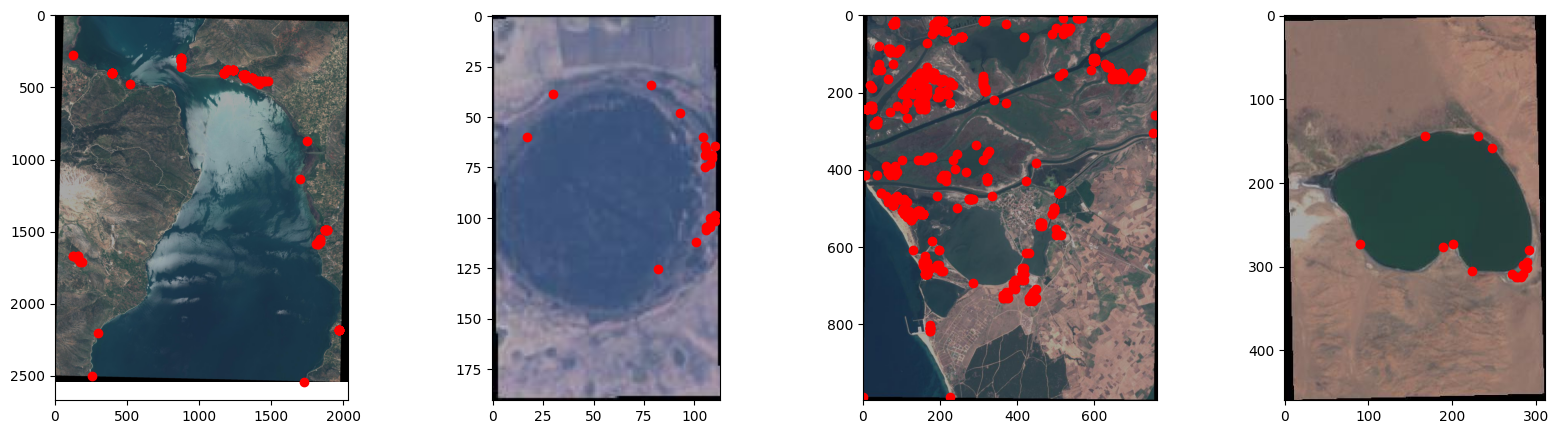

In [ ]:
data_file = os.path.join(data_path, "train.jsonl")

def read_n_lines(file_path: str, n: int) -> List[str]:
    with open(file_path, 'r') as file:
        lines = [next(file).strip() for _ in range(n)]
    return lines


def extract_numbers_from_seg(lng_string):
  """Extracts numbers between '<seg>' tags and separates them by semicolon."""

  all_numbers_list = []
  segments = lng_string.split(';')
  for segment in segments:
      numbers_in_segment = []
      matches = re.findall(r'<seg(.*?)>', segment)
      for match in matches:
          numbers = [int(num) for num in re.findall(r'\d+', match)]
          numbers_in_segment.extend(numbers)
      all_numbers_list.append(numbers_in_segment)

  return all_numbers_list


def get_original_coordinate(number: int, im_dimension:int, factor: int =128):
  return number*im_dimension / factor


images = []
lines = read_n_lines(data_file, n=30) # get n images
first = json.loads(lines[0])
CLASSES = first.get('prefix').split(" ")[-1]

new_lines = [lines[2], lines[6], lines[9], lines[10]] # select 4 lines to plot

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

for counter, line in enumerate(new_lines):
    data = json.loads(line)
    list_contours = extract_numbers_from_seg(data.get("suffix"))

    image = cv2.imread(os.path.join(data_path, data.get('image')))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    (h, w, _) = image.shape

    # get the dict: {contour_i: ([coords x],[coords_y])}
    contours_coords = dict()
    for i, cnt_coords in enumerate(list_contours):
      orig_y_vals = [get_original_coordinate(int(cnt_coords[y]), h) for y in range(0, len(cnt_coords), 2)] # pares son y
      orig_x_vals = [get_original_coordinate(int(cnt_coords[x]), w) for x in range(1, len(cnt_coords), 2)] # impares son x
      contours_coords[i] = (orig_x_vals, orig_y_vals)

    # Make the plot
    axs[counter].imshow(image)
    for _, (x,y) in contours_coords.items():
      axs[counter].plot(x, y, 'ro')
plt.show()




In [ ]:
# code taken from https://github.com/google-gemini/gemma-cookbook/blob/main/PaliGemma/Referring_expression_segmentation_in_images_using_PaliGemma.ipynb

def parse_segments(detokenized_output: str) -> tuple[np.ndarray, np.ndarray]:

  # Using \d{3} to indicate exactly three digits
  matches = re.finditer(
      '(\d\d\d\d)>(\d\d\d\d)>(\d\d\d\d)>(\d\d\d\d)>'
      + ''.join(f'(\d\d\d)>' for i in range(16)),
      detokenized_output,
  )

  boxes, segs = [], []
  fmt_box = lambda x: float(x) / 1024.0
  for m in matches:
    print(m)
    d = m.groupdict()
    boxes.append([fmt_box(d['y0']), fmt_box(d['x0']), fmt_box(d['y1']), fmt_box(d['x1'])])
    segs.append([int(d[f's{i}']) for i in range(16)])

  coordinates = boxes[0]
  mask = np.array(reconstruct_masks(np.array(segs)))

  return coordinates, mask

In [ ]:
datap = json.loads(lines[2])
detections = data.get("suffix").split(";")

In [ ]:
# for detection in detections, here detection = detections[0]
paligemma_output, label = detections[0].split(" ")

In [ ]:
points = np.array(extract_numbers_from_seg(detections[0]))

In [ ]:
mask = np.array(reconstruct_masks(points))

In [ ]:
print(mask[0].shape)
mask[0]


(64, 64, 1)


array([[[-0.947342  ],
        [-0.8085486 ],
        [-0.08873831],
        ...,
        [-0.99486834],
        [-0.9963307 ],
        [-0.9874082 ]],

       [[-1.0009717 ],
        [-0.80340064],
        [ 0.19741674],
        ...,
        [-0.9992885 ],
        [-0.99724454],
        [-0.99850506]],

       [[-0.96441907],
        [-0.6482803 ],
        [ 0.43855405],
        ...,
        [-0.99921745],
        [-0.9977543 ],
        [-0.9955844 ]],

       ...,

       [[-0.9793977 ],
        [-0.9805774 ],
        [-0.9844349 ],
        ...,
        [ 0.08932514],
        [-0.38487846],
        [-0.6009875 ]],

       [[-0.99290305],
        [-0.98867506],
        [-0.98927504],
        ...,
        [ 0.20301767],
        [-0.28838408],
        [-0.63153595]],

       [[-0.99112743],
        [-0.9960887 ],
        [-0.99804395],
        ...,
        [ 0.04471953],
        [-0.31842554],
        [-0.69323266]]], dtype=float32)

# Select the runtime

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `T4 GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Mon Nov 18 21:04:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0              48W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

# Get access to PaliGemma

Before using PaliGemma for the first time, you must request access to the model through Kaggle by completing the following steps:

1. Log in to [`Kaggle`](https://www.kaggle.com), or create a new Kaggle account if you don't already have one.
1. Go to the [`PaliGemma Model Card`](https://www.kaggle.com/models/google/paligemma/) and click `Request Access`.
1. Complete the consent form and accept the terms and conditions.

### Configure your API keys

To use PaliGemma, you need to provide your Kaggle username and Kaggle API key. Follow these steps:

- Open your [`Kaggle Settings`](https://www.kaggle.com/settings) page. Click `Create New Token`. This will download a `kaggle.json` file containing your API credentials.

- In Colab, go to the left pane and click on `Secrets` (🔑).
    - Store Kaggle Username under the name `KAGGLE_USERNAME`.
    - Store Kaggle API Key under the name `KAGGLE_KEY`.


### Set environment variables

Set the environment variables for `KAGGLE_USERNAME` and `KAGGLE_KEY`.

In [ ]:
# Note: `userdata.get` is a Colab API. If you're not using Colab, set the env
# vars as appropriate or make your credentials available in ~/.kaggle/kaggle.json

os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')

### Fetch the `big_vision` repository and install related dependencies

Download the `big_vision` repository to your Colab notebook from GitHub and install dependencies related to `big_vision` by running the following code.

In [ ]:
# TPUs with
if "COLAB_TPU_ADDR" in os.environ:
  raise "It seems you are using Colab with remote TPUs which is not supported."

# Fetch big_vision repository if python doesn't know about it and install
# dependencies needed for this notebook.
if not os.path.exists("big_vision_repo"):
  !git clone --quiet --branch=main --depth=1 \
     https://github.com/google-research/big_vision big_vision_repo

# Append big_vision code to python import path
if "big_vision_repo" not in sys.path:
  sys.path.append("big_vision_repo")

# Install missing dependencies. Assume jax~=0.4.25 with GPU available.
!pip3 install -q "overrides" "ml_collections" "einops~=0.7" "sentencepiece"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 2.6 MB/s eta 0:00:00


### Import JAX and other dependencies

Import JAX and other dependencies required for PaliGemma, like TensorFlow and NumPy.

In [ ]:
# Import model definition from big_vision
import ml_collections
from big_vision.models.proj.paligemma import paligemma
from big_vision.trainers.proj.paligemma import predict_fns

# Import big vision utilities
import big_vision.datasets.jsonl
import big_vision.utils
import big_vision.sharding
import big_vision.evaluators.proj.paligemma.transfers.segmentation as segeval


# Don't let TF use the GPU or TPUs
tf.config.set_visible_devices([], "GPU")
tf.config.set_visible_devices([], "TPU")

backend = jax.extend.backend.get_backend() #jax.lib.xla_bridge.get_backend()
print(f"JAX version:  {jax.__version__}")
print(f"JAX platform: {backend.platform}")
print(f"JAX devices:  {jax.device_count()}")

JAX version:  0.4.33
JAX platform: gpu
JAX devices:  1


## Download and configure the model

In this step, you'll download the model checkpoint and configure it so that you can fine-tune it later on. This step shows you how to move model parameters into TPU memory, which is useful for fine-tuning models on devices with limited resources.

### Download the model checkpoint

PaliGemma includes several model variations. For this tutorial, you'll use the base [JAX/FLAX PaliGemma 3B weight model](https://www.kaggle.com/models/google/paligemma/jax/paligemma-3b-pt-224).

Download the `float16` version of the model checkpoint from Kaggle by running the following code. This process takes several minutes to complete.

In [ ]:
MODEL_PATH = "./pt_224_128.params.f16.npz"
if not os.path.exists(MODEL_PATH):
    print("Downloading the checkpoint from Kaggle, this could take a few minutes....")
    # Note: kaggle archive contains the same checkpoint in multiple formats.
    # Download only the float16 model.
    MODEL_PATH = kagglehub.model_download('google/paligemma/jax/paligemma-3b-pt-224', 'paligemma-3b-pt-224.f16.npz')
    print(f"Model path: {MODEL_PATH}")

TOKENIZER_PATH = "./paligemma_tokenizer.model"
if not os.path.exists(TOKENIZER_PATH):
    print("Downloading the model tokenizer...")
    !gsutil cp gs://big_vision/paligemma_tokenizer.model {TOKENIZER_PATH}
    print(f"Tokenizer path: {TOKENIZER_PATH}")

100%|██████████| 5.45G/5.45G [01:27<00:00, 66.9MB/s]


Model path: /root/.cache/kagglehub/models/google/paligemma/jax/paligemma-3b-pt-224/1/paligemma-3b-pt-224.f16.npz
Copying gs://big_vision/paligemma_tokenizer.model...
- [1 files][  4.1 MiB/  4.1 MiB]                                                
Operation completed over 1 objects/4.1 MiB.                                      
Tokenizer path: ./paligemma_tokenizer.model


In [ ]:
print(MODEL_PATH)
print(TOKENIZER_PATH)

/root/.cache/kagglehub/models/google/paligemma/jax/paligemma-3b-pt-224/1/paligemma-3b-pt-224.f16.npz
./paligemma_tokenizer.model


### Configure the model

It's time to actually start configuring the model that you're going to use.

For this notebook, you need to be able to fit your model onto a T4 GPU. Having a limited resource like space constraints means that you have to be mindful of how your model is configured.

If you fine-tune every parameter, your model won't be able to run in the notebook environment. As a result, in this part of the notebook, you'll configure your model so that it has the ability to freeze some of the parameters, and only fine-tune the parameters that really need to be fine-tuned for the model to give you accurate results. In LLMs, parameters are said to be *frozen* when they are no longer actively being used to train the model.

In order to configure your model, you need to:

* Initialize the `model_config` as a [`FrozenConfigDict`](https://github.com/google/ml_collections/tree/master#frozenconfigdict) so that you can freeze some of the parameters and keep memory usage low
* Initialize an instance of the PaliGemma `Model` class using the `model_config` as its configurations
* Load the model parameters into RAM
* Define a `decode` function to sample outputs from the model

This code in this cell takes about a minute to run to completion.

In [ ]:
# Define model
model_config = ml_collections.FrozenConfigDict({
    "llm": {"vocab_size": 257_152},
    "img": {"variant": "So400m/14", "pool_type": "none", "scan": True, "dtype_mm": "float16"}
})
model = paligemma.Model(**model_config)
tokenizer = sentencepiece.SentencePieceProcessor(TOKENIZER_PATH)

# Load params - this can take up to 1 minute in T4 colabs.
params = paligemma.load(None, MODEL_PATH, model_config)

# Define `decode` function to sample outputs from the model.
decode_fn = predict_fns.get_all(model)['decode']
decode = functools.partial(decode_fn, devices=jax.devices(), eos_token=tokenizer.eos_id())

### Move model parameters into GPU/TPU memory

Now you need to move the model parameters into GPU/TPU memory. First, shard the parameters across the available GPUs, then load the parameters. Here, you'll load the parameters sequentially. This process takes longer than loading them simultaneously, but it requires more RAM than you have available in this notebook.

Finally, print out all of the parameters to see what type each individual parameter is cast to. Frozen parameters are kept as `float16`, while the trainable parameters are cast to `float32`. When you inspect the list, you'll see that most of the parameters have been frozen and are `float16`.

In [ ]:
# Create a pytree mask of the trainable params.
def is_trainable_param(name, param):  # pylint: disable=unused-argument
  if name.startswith("llm/layers/attn/"):  return True
  if name.startswith("llm/"):              return False
  if name.startswith("img/"):              return False
  raise ValueError(f"Unexpected param name {name}")
trainable_mask = big_vision.utils.tree_map_with_names(is_trainable_param, params)

# If more than one device is available (e.g. multiple GPUs) the parameters can
# be sharded across them to reduce HBM usage per device.
mesh = jax.sharding.Mesh(jax.devices(), ("data"))

data_sharding = jax.sharding.NamedSharding(
    mesh, jax.sharding.PartitionSpec("data"))

params_sharding = big_vision.sharding.infer_sharding(
    params, strategy=[('.*', 'fsdp(axis="data")')], mesh=mesh)

# Yes: Some donated buffers are not usable.
warnings.filterwarnings(
    "ignore", message="Some donated buffers were not usable")

@functools.partial(jax.jit, donate_argnums=(0,), static_argnums=(1,))
def maybe_cast_to_f32(params, trainable):
  return jax.tree.map(lambda p, m: p.astype(jnp.float32) if m else p,
                      params, trainable)

# Loading all params in simultaneous - albeit much faster and more succinct -
# requires more RAM than the T4 colab runtimes have by default.
# Instead we do it param by param.
params, treedef = jax.tree.flatten(params)
sharding_leaves = jax.tree.leaves(params_sharding)
trainable_leaves = jax.tree.leaves(trainable_mask)
for idx, (sharding, trainable) in enumerate(zip(sharding_leaves, trainable_leaves)):
  params[idx] = big_vision.utils.reshard(params[idx], sharding)
  params[idx] = maybe_cast_to_f32(params[idx], trainable)
  params[idx].block_until_ready()
params = jax.tree.unflatten(treedef, params)

# Print params to show what the model is made of.
def parameter_overview(params):
  for path, arr in big_vision.utils.tree_flatten_with_names(params)[0]:
    print(f"{path:80s} {str(arr.shape):22s} {arr.dtype}")

print(" == Model params == ")
parameter_overview(params)

 == Model params == 
img/Transformer/encoder_norm/bias                                                (1152,)                float16
img/Transformer/encoder_norm/scale                                               (1152,)                float16
img/Transformer/encoderblock/LayerNorm_0/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_0/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/bias                             (27, 4304)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/kernel                           (27, 1152, 4304)       float16
img/Transformer/encoderblock/MlpBlock_0/Dense_1/bias                             (2

## Prepare to tune the model

Now that your model is configured, you can tune it. In this step, you'll create your model's inputs as well as the training and validation iterators, view the training examples, and define the training and validation loops.

### Create model inputs

The model checkpoint you're using has already been trained on images of various aspect ratios that have been resized to 224x224 pixels, and to handle tokenized texts.

The code below defines three functions that you'll use in the next step create the model's inputs:

* **`preprocess_image`:** Normalizes the image data. In this case, pre-processing converts the passed-in image to greyscale, removes the alpha layer, and resizes the passed-in image to the size required by the model for image inputs (224x224 pixels).
* **`preprocess_tokens`:** Splits the tokens up and adds flags to mark whether a token is a prefix or suffix token. These flags will be used later on in the code, during the training step and the evaluation loop.
* **`postprocess_tokens`:** Removes any tokens left at and/or after the end-of-sequence (EOS) token and returns the remaining decoded tokens.


In [ ]:
def preprocess_image(image, size: int):
  # Model has been trained to handle images of different aspects ratios
  # resized to 224x224 in the range [-1, 1]. Bilinear and antialias resize
  # options are helpful to improve quality in some tasks.
  image = np.asarray(image)
  if image.ndim == 2:  # Convert image without last channel into greyscale.
    image = np.stack((image,)*3, axis=-1)
  image = image[..., :3]  # Remove alpha layer.
  assert image.shape[-1] == 3

  image = tf.constant(image)
  image = tf.image.resize(image, (size, size), method='bilinear', antialias=True)
  return image.numpy() / 127.5 - 1.0  # [0, 255]->[-1,1]


def preprocess_tokens(prefix, suffix=None, seqlen=None):
  """Tokenizes prefix and suffix of the JSONL file."""
  # Model has been trained to handle tokenized text composed of a prefix with
  # full attention and a suffix with causal attention.
  separator = "\n"
  tokens = tokenizer.encode(prefix, add_bos=True) + tokenizer.encode(separator)
  mask_ar = [0] * len(tokens)    # 0 to use full attention for prefix.
  mask_loss = [0] * len(tokens)  # 0 to not use prefix tokens in the loss.

  if suffix:
    suffix = tokenizer.encode(suffix, add_eos=True)
    tokens += suffix
    mask_ar += [1] * len(suffix)    # 1 to use causal attention for suffix.
    mask_loss += [1] * len(suffix)  # 1 to use suffix tokens in the loss.

  mask_input = [1] * len(tokens)    # 1 if it's a token, 0 if padding.
  if seqlen:
    padding = [0] * max(0, seqlen - len(tokens))
    tokens = tokens[:seqlen] + padding
    mask_ar = mask_ar[:seqlen] + padding
    mask_loss = mask_loss[:seqlen] + padding
    mask_input = mask_input[:seqlen] + padding

  return jax.tree.map(np.array, (tokens, mask_ar, mask_loss, mask_input))

def postprocess_tokens(tokens):
  """ DETOKENIZES MODEL INPUT."""
  tokens = tokens.tolist()  # np.array to list[int]
  try:  # Remove tokens at and after EOS if any.
    eos_pos = tokens.index(tokenizer.eos_id())
    tokens = tokens[:eos_pos]
  except ValueError:
    pass
  return tokenizer.decode(tokens)

### Create the training and validation iterators

Create two iterators:

*   A **training iterator** to allow the training process to go through the data in chunks rather than processing it all at once. This allows you to do some data pre-processing before use.
*   A **validation iterator** that allows the training process to iterate over the validation dataset to see how well the tuned model aligned with the provided results.

In [ ]:
train_dataset = big_vision.datasets.jsonl.DataSource(
    os.path.join(data_path, "train.jsonl"),
    fopen_keys={"image": data_path})

test_dataset = big_vision.datasets.jsonl.DataSource(
    os.path.join(data_path, "test.jsonl"),
    fopen_keys={"image": data_path})


In [ ]:
train_dataset.examples[0]

{'image': '/content/drive/MyDrive/paligemma_for_segmentation/water_bodies/water_body_1478.jpg',
 'prefix': 'segment water',
 'suffix': '<loc0555><loc0936><loc0674><loc0990><seg084><seg118><seg073><seg123><seg080><seg123><seg076><seg123><seg076><seg123><seg074><seg122><seg070><seg122><seg077><seg121> water; <loc0254><loc0039><loc0767><loc0975><seg090><seg060><seg096><seg095><seg084><seg037><seg093><seg086><seg051><seg116><seg032><seg066><seg089><seg112><seg073><seg024> water; <loc0172><loc0120><loc0178><loc0153><seg022><seg018><seg022><seg016><seg022><seg016><seg022><seg018><seg022><seg017><seg022><seg017><seg022><seg017><seg022><seg015> water; <loc0102><loc0480><loc0112><loc0492><seg013><seg060><seg013><seg060><seg013><seg060><seg014><seg060><seg014><seg060><seg013><seg061><seg013><seg061><seg014><seg060> water'}

In [ ]:
type(train_dataset.examples[0])

dict

In [ ]:
def train_data_iterator():
  """Never ending iterator over training examples."""
  # Shuffle examples and repeat so one can train for many epochs.
  dataset = train_dataset.get_tfdata().shuffle(1_000).repeat()

  for example in dataset.as_numpy_iterator():
    image = Image.open(io.BytesIO(example["image"])) # it opens the original image
    image = preprocess_image(image, size=NEW_IMAGE_SIZE) # reshapes to NEW_IMAGE_SIZE

    prefix = example["prefix"].decode().lower()
    suffix = example["suffix"].decode().lower()
    tokens, mask_ar, mask_loss, _ = preprocess_tokens(prefix, suffix, SEQLEN)
    label, _, _, _ = preprocess_tokens(suffix, seqlen=SEQLEN)

    yield {
        "image": np.asarray(image),
        "text": np.asarray(tokens),
        "label": np.asarray(label),
        "mask_ar": np.asarray(mask_ar),
        "mask_loss": np.asarray(mask_loss),
    }


def validation_data_iterator():
  """Single iterator over validation examples."""
  dataset = val_dataset.get_tfdata(ordered=True)

  for example in dataset.as_numpy_iterator():
    image = Image.open(io.BytesIO(example["image"]))
    image = preprocess_image(image, size=NEW_IMAGE_SIZE)

    prefix = example["prefix"].decode().lower()
    suffix = example["suffix"].decode().lower()
    tokens, mask_ar, _, mask_input = preprocess_tokens(prefix, seqlen=SEQLEN)
    label, _, _, _ = preprocess_tokens(suffix, seqlen=SEQLEN)

    yield {
        "image": np.asarray(image),
        "text": np.asarray(tokens),
        "label": np.asarray(label),
        "mask_ar": np.asarray(mask_ar),
        "mask_input": np.asarray(mask_input),
    }

def test_data_iterator():
  """Single iterator over validation examples."""
  dataset = test_dataset.get_tfdata(ordered=True)

  for example in dataset.as_numpy_iterator():
    image = Image.open(io.BytesIO(example["image"]))
    image = preprocess_image(image, size=NEW_IMAGE_SIZE)

    prefix = example["prefix"].decode().lower()
    suffix = example["suffix"].decode().lower()
    tokens, mask_ar, _, mask_input = preprocess_tokens(prefix, seqlen=SEQLEN)
    label, _, _, _ = preprocess_tokens(suffix, seqlen=SEQLEN)

    yield {
        "image": np.asarray(image),
        "text": np.asarray(tokens),
        "label": np.asarray(label),
        "mask_ar": np.asarray(mask_ar),
        "mask_input": np.asarray(mask_input),
    }



### View Preprocessed data

In this notebook, the training data contains XXXX images that are paired with their corresponding water body contours.

The code below plots a random selection of images with their water segments from the training data set.  

In [ ]:
def render_example(image, text):
    image_back = ((image + 1)/2 * 255).astype(np.uint8) #still with size 224 X 224
    caption = postprocess_tokens(text)
    list_cnts = extract_numbers_from_seg(caption)

    # get the dict: {contour_i: ([coords x],[coords_y])}
    contours_coords = dict()
    for i, cnt_coords in enumerate(list_cnts):
      y_vals = [get_original_coordinate(int(cnt_coords[y]), 224) for y in range(0, len(cnt_coords), 2)] # pares son y
      x_vals = [get_original_coordinate(int(cnt_coords[x]), 224) for x in range(1, len(cnt_coords), 2)] # impares son x
      contours_coords[i] = (x_vals, y_vals)

    return image_back, contours_coords


In [ ]:
nplots = 3
# fig, ax = plt.subplots(1, nplots, figsize=(20, 5))
for idx, example in zip(range(nplots), test_data_iterator()):
  print(example)
#     image = example["image"]
#     label= example["label"]
#     new_image, cont_coords= render_example(image, label)
#     ax[idx].imshow(new_image)
#     for _, (x,y) in cont_coords.items():
#       if len(x) == len(y):
#         ax[idx].plot(x, y, 'ro')

# plt.show()

{'image': array([[[-1.        , -0.9843137 , -0.9843137 ],
        [-1.        , -0.9843137 , -0.9843137 ],
        [-1.        , -0.9843137 , -0.97944677],
        ...,
        [-0.99702376, -1.        , -0.9902662 ],
        [-0.99215686, -1.        , -1.        ],
        [-0.99215686, -1.        , -1.        ]],

       [[-1.        , -0.9843137 , -0.9764706 ],
        [-1.        , -0.9782563 , -0.98252803],
        [-0.9902661 , -0.9764706 , -0.96971285],
        ...,
        [-0.99702376, -1.        , -0.9843137 ],
        [-0.99215686, -1.        , -0.98788536],
        [-0.99215686, -1.        , -1.        ]],

       [[-1.        , -1.        , -1.        ],
        [-0.99394256, -0.99394256, -1.        ],
        [-0.98242295, -0.99215686, -0.9902661 ],
        ...,
        [-0.99702376, -1.        , -0.9843137 ],
        [-0.99215686, -1.        , -0.9843137 ],
        [-0.99215686, -1.        , -0.9843137 ]],

       ...,

       [[-1.        , -0.9764706 , -0.9843137 ],
 

In [ ]:
reconstruct_masks = segeval.get_reconstruct_masks('oi')

### Define the training and evaluation loops

Define the training loop to train the model on the provided dataset, and the evaluation loop to look at all of the examples in the validation dataset and make its predictions.

#### Defining the training loop

The `update_fn` function defines the training step. During the training step, the loss per example is calculated and stochastic gradient descent (SGD) is applied to the trainable parameters.

Recall that earlier in the notebook, you included flags in the `preprocess_tokens` function that included `mask_loss`. You'll use the `mask_loss` flag here to exclude prefix and padded tokens from the loss. Without it, the loss calculation will be skewed. You also need to normalize each example, since each of them has a different number of tokens. After the prefix and padded tokens have been excluded and the examples have been normalized, you can calculate the loss per example.

The training step also includes a function to apply an SGD to optimize the training.

#### Defining the evaluation loop

The `make_predictions` function is your evaluation loop. The evaluation loop is fairly straight forward with one notable change. If you recall from the beginning of the notebook, you only have 90 examples in your training data set. This is a very small amount of training examples, and your model ends up not having enough examples for the batch size when you run the training. This means that in the evaluation loop, you need to pad the batch by repeating examples.

To make sure that your evaluation loop only counts actual examples and not the padded examples, you have to apply a mask to the padded examples that excludes them from the output.

In [ ]:
# The main update_fn using a simple stochastic gradient descent (SGD).
@functools.partial(jax.jit, donate_argnums=(0,))
def update_fn(params, batch, learning_rate):
  imgs, txts, mask_ar = batch["image"], batch["text"], batch["mask_ar"]

  def loss_fn(params):
    text_logits, _ = model.apply({"params": params}, imgs, txts[:, :-1], mask_ar[:, :-1], train=True)
    logp = jax.nn.log_softmax(text_logits, axis=-1)

    # The model takes as input txts[:, :-1] but the loss is defined as predicting
    # next tokens txts[:, 1:]. Additionally, mask_loss[:, 1:] indicates which tokens
    # are part of the loss (e.g. prefix and padded tokens are not included).
    mask_loss = batch["mask_loss"][:, 1:]
    targets = jax.nn.one_hot(txts[:, 1:], text_logits.shape[-1])

    # Compute the loss per example. i.e. the mean of per token pplx.
    # Since each example has a different number of tokens we normalize it.
    token_pplx = jnp.sum(logp * targets, axis=-1)  # sum across vocab_size.
    example_loss = -jnp.sum(token_pplx * mask_loss, axis=-1)  # sum across seq_len.
    example_loss /= jnp.clip(jnp.sum(mask_loss, -1), 1)  # weight by num of tokens.

    # batch_loss: mean of per example loss.
    return jnp.mean(example_loss)

  loss, grads = jax.value_and_grad(loss_fn)(params)

  # Apply gradients to trainable params using SGD.
  def apply_grad(param, gradient, trainable):
    if not trainable: return param
    return param - learning_rate * gradient

  params = jax.tree_util.tree_map(apply_grad, params, grads, trainable_mask)

  return params, loss

# Evaluation/inference loop.
def make_predictions(data_iterator, num_examples=None,
                     batch_size=4, seqlen=SEQLEN, sampler="greedy"):
  outputs = []
  while True:
    # Construct a list of examples in the batch.
    examples = []
    try:
      for _ in range(batch_size):
        examples.append(next(data_iterator))
        examples[-1]["_mask"] = np.array(True)  # Indicates true example.

    except StopIteration:
      if len(examples) == 0:
        return outputs

    # Not enough examples to complete a batch. Pad by repeating last example.
    while len(examples) % batch_size:
      examples.append(dict(examples[-1]))
      examples[-1]["_mask"] = np.array(False)  # Indicates padding example.

    # Convert list of examples into a dict of np.arrays and load onto devices.
    batch = jax.tree.map(lambda *x: np.stack(x), *examples)
    batch = big_vision.utils.reshard(batch, data_sharding)

    # Make model predictions
    tokens = decode({"params": params}, batch=batch,
                    max_decode_len=seqlen, sampler=sampler)


    # Fetch model predictions to device and detokenize.
    tokens, mask = jax.device_get((tokens, batch["_mask"]))
    tokens = tokens[mask]  # remove padding examples.
    labels = [postprocess_tokens(e["label"]) for e in examples]
    responses = [postprocess_tokens(t) for t in tokens]

    # print("tokens")
    # print([t for i, t in enumerate(tokens) if i ==0])
    # print("labels")
    # print([e["label"] for i, e in enumerate(examples) if i ==0])

    # Append to html output.
    for example, label, response in zip(examples, labels, responses):
      outputs.append((example["image"], label, response))
      if num_examples and len(outputs) >= num_examples:
        return outputs

## Tune the model

Now that you've set everything up and taken a look at the training data, it's time to finally tune the model. The code below runs the training loop for the model for 64 steps and prints the learning rate (`lr` in the printed output) and loss rate for each step.

Every 16 steps, the model prints what its predictions are at that step in the training. This code prints out predictions for the same set of images so that you can see the model's ability to predict descriptions improve over time.

At earlier steps in the training, there's likely issues with the descriptions, such as repeated sentences as the model gets stuck in its predictive loop or unfinished sentences. The model's predictions become steadily more accurate as training progresses. By step 64, the model's predictions should closely resemble the descriptions provided by the training data.

This process takes around 15 minutes to complete on T4 TPUs.

In [ ]:
# Run a short training loop with cosine learning rate schedule.
#
# Note: the first step can be quite slow on some machines (up to several minutes)
# due to XLA compilation of the jax.jit'd function.
#
%%time

BATCH_SIZE = 8
TRAIN_EXAMPLES = 500
LEARNING_RATE = 0.005

TRAIN_STEPS = TRAIN_EXAMPLES // BATCH_SIZE # 10
EVAL_STEPS =  TRAIN_STEPS // 8 #3

train_data_it = train_data_iterator()

sched_fn = big_vision.utils.create_learning_rate_schedule(
    total_steps=TRAIN_STEPS+1, base=LEARNING_RATE,
    decay_type="cosine", warmup_percent=0.10)

for step in range(1, TRAIN_STEPS+1):
  # Make list of N training examples.
  examples = [next(train_data_it) for _ in range(BATCH_SIZE)]

  # Convert list of examples into a dict of np.arrays and load onto devices.
  batch = jax.tree.map(lambda *x: np.stack(x), *examples)
  batch = big_vision.utils.reshard(batch, data_sharding)

  # Training step and report training loss
  learning_rate = sched_fn(step)
  params, loss = update_fn(params, batch, learning_rate)

  loss = jax.device_get(loss)
  print(f"step: {step:2d}/{TRAIN_STEPS:2d}   lr: {learning_rate:.5f}   loss: {loss:.4f}")

  # if (step % EVAL_STEPS) == 0:
  #   print(f"Model predictions at step {step}")
  #   for image, _, caption in make_predictions(validation_data_iterator(), num_examples=4, batch_size=4):
  #     new_image, cont_coords= render_example(image, caption)
  #     fig, ax = plt.subplots(1, 1, figsize=(5, 5))
  #     ax.imshow(new_image)
  #     for _, (x,y) in cont_coords.items():
  #       if len(x) == len(y):
  #         ax.plot(x, y, 'r-')
  #     plt.show()


step:  1/62   lr: 0.00083   loss: 7.0659
step:  2/62   lr: 0.00167   loss: 6.8651
step:  3/62   lr: 0.00250   loss: 6.6042
step:  4/62   lr: 0.00333   loss: 6.0359
step:  5/62   lr: 0.00417   loss: 5.7199
step:  6/62   lr: 0.00500   loss: 6.0460
step:  7/62   lr: 0.00500   loss: 5.9955
step:  8/62   lr: 0.00498   loss: 5.7420
step:  9/62   lr: 0.00497   loss: 5.6784
step: 10/62   lr: 0.00494   loss: 5.1832
step: 11/62   lr: 0.00491   loss: 6.9284
step: 12/62   lr: 0.00486   loss: 5.3134
step: 13/62   lr: 0.00482   loss: 5.2166
step: 14/62   lr: 0.00476   loss: 12.5343
step: 15/62   lr: 0.00470   loss: 6.8344
step: 16/62   lr: 0.00463   loss: 5.7688
step: 17/62   lr: 0.00455   loss: 6.3974
step: 18/62   lr: 0.00447   loss: 5.5617
step: 19/62   lr: 0.00439   loss: 5.3502
step: 20/62   lr: 0.00429   loss: 5.1271
step: 21/62   lr: 0.00419   loss: 4.9025
step: 22/62   lr: 0.00409   loss: 4.4840
step: 23/62   lr: 0.00398   loss: 4.8011
step: 24/62   lr: 0.00387   loss: 4.5987
step: 25/62   l

## Evaluate fine-tuned model

In [ ]:
def render_label(label: str) -> dict:
  list_contours = extract_numbers_from_seg(label)

  # get the dict: {contour_i: ([coords x],[coords_y])}
  contours_coords = dict()
  for i, cnt_coords in enumerate(list_contours):
    y_vals = [get_original_coordinate(int(cnt_coords[y]), 224) for y in range(0, len(cnt_coords), 2)] # pares son y
    x_vals = [get_original_coordinate(int(cnt_coords[x]), 224) for x in range(1, len(cnt_coords), 2)] # impares son x
    contours_coords[i] = (x_vals, y_vals)
  return contours_coords


def render_example(image, text):
  image_back = ((image + 1)/2 * 255).astype(np.uint8) #still with size 224 X 224
  caption = postprocess_tokens(text)
  list_cnts = extract_numbers_from_seg(caption)

  # get the dict: {contour_i: ([coords x],[coords_y])}
  contours_coords = dict()
  for i, cnt_coords in enumerate(list_cnts):
    y_vals = [get_original_coordinate(int(cnt_coords[y]), 224) for y in range(0, len(cnt_coords), 2)] # pares son y
    x_vals = [get_original_coordinate(int(cnt_coords[x]), 224) for x in range(1, len(cnt_coords), 2)] # impares son x
    contours_coords[i] = (x_vals, y_vals)

  return image_back, contours_coords


counter 0

counter 1

counter 2

counter 3
<loc0000><loc0066><loc1015><loc0763><seg014><seg007><seg094><seg094><seg094><seg094><seg094><seg094><seg095><seg058><seg058><seg058><seg040><seg040><seg040><seg040> water
counter 4
<loc0000><loc0000><loc1013><loc1023><seg010><seg090><seg090><seg090><seg090><seg120><seg120><seg120><seg073><seg073><seg073><seg073><seg073><seg073><seg073> water
counter 5
<loc0238><loc0036><loc0789><loc1023><seg110><seg123><seg123><seg123><seg123><seg123><seg123><seg123><seg123><seg123><seg123><seg123><seg123><seg123><seg123><seg123> water
counter 6
<loc0127><loc0022><loc1023><loc0975><seg090><seg010><seg090><seg090><seg090><seg090><seg082><seg082><seg042><seg042><seg082><seg042><seg042><seg042><seg042><seg042> water
counter 7

counter 8

counter 9

counter 10
<loc0375><loc0000><loc0629><loc1023><seg123><seg123><seg123><seg123><seg123><seg123><seg123><seg123><seg123><seg123><seg123><seg123><seg123><seg123><seg123><seg123> water
counter 11
<loc0187><loc0000><loc083

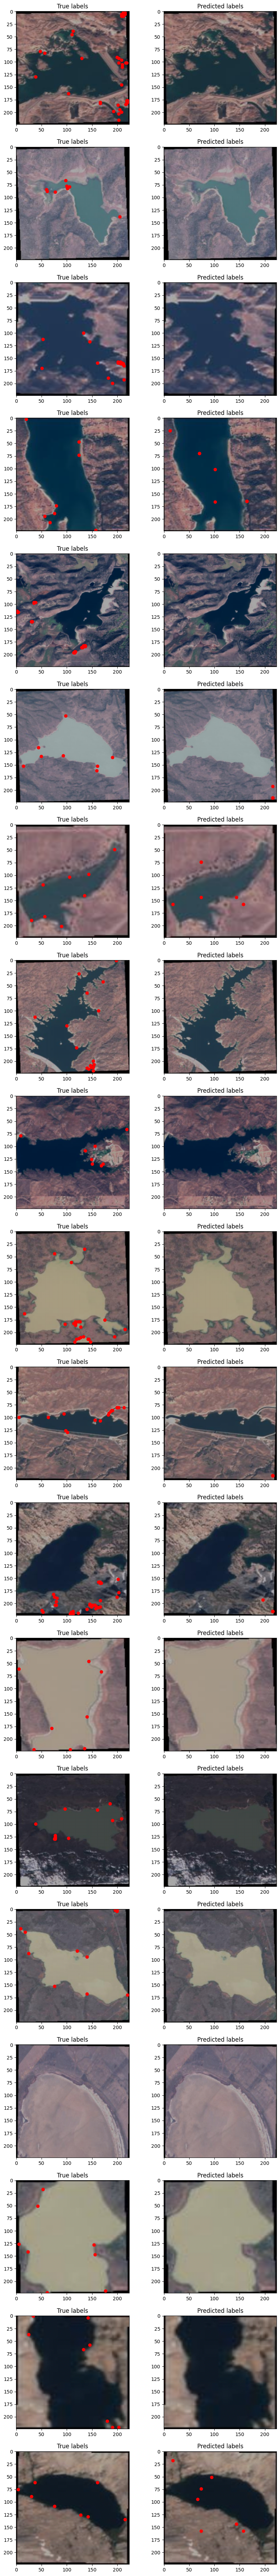

In [ ]:
nplots = len(test_dataset.examples)

fig, ax = plt.subplots(nplots, 2, figsize=(10, 5*nplots))
counter = 0
for nimage, true_label, prediction in make_predictions(test_data_iterator(), num_examples=nplots, batch_size=BATCH_SIZE):

  new_image = ((nimage + 1)/2 * 255).astype(np.uint8) #still with size NEW_IMAGE_SIZE
  cnt_true_labels = render_label(true_label)
  cnt_pred_labels = render_label(prediction)
  # new_image, cnt_true_labels = render_example(nimage, true_label)
  # _, cnt_pred_labels = render_label(nimage, prediction)

  ax[counter][0].imshow(new_image)
  for _, (x,y) in cnt_true_labels.items():
    if len(x) == len(y):
      ax[counter][0].plot(x, y, 'ro')
      ax[counter][0].set_title("True labels")

  ax[counter][1].imshow(new_image)
  for _, (x,y) in cnt_pred_labels.items():
    if len(x) == len(y):
      ax[counter][1].plot(x, y, 'ro')
      ax[counter][1].set_title("Predicted labels")

  counter +=1


# print("Evaluation of paligemma")
plt.show()

## Save fine-tuned model locally

In [ ]:
if SAVE_MODEL:

  TARGET_MODEL_DIR = os.path.join(root_path, "finetuned_model")
  TARGET_MODEL_NAME = os.path.join(TARGET_MODEL_DIR, "paligemma-seg-3b-pt-224.f16.npz")

  os.makedirs(TARGET_MODEL_DIR, exist_ok=True)

  flat, _ = big_vision.utils.tree_flatten_with_names(params)
  with open(TARGET_MODEL_NAME, "wb") as f:
    np.savez(f, **{k: v for k, v in flat})

# Congratulations
This is the end of the notebook